### Install the dependencies 

In [1]:
!pip install -q condacolab

import condacolab

condacolab.install()

!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade mapclassify
!pip install --upgrade folium
!pip install --upgrade pyproj
!pip install --upgrade rtree

✨🍰✨ Everything looks OK!


In [2]:
!pip install --upgrade cffi==1.15.0

### Import

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mapclassify import classify
import mapclassify

### Get NYC map df

In [4]:
path_to_data = gpd.datasets.get_path("nybb")
map = gpd.read_file(path_to_data)
map

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


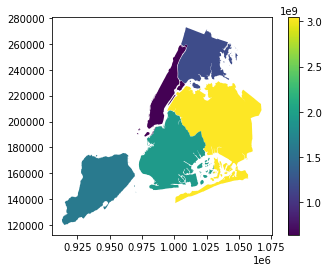

In [5]:
map["area"] = map.area
map.plot("area", legend=True)

In [6]:
# map.explore("area", legend=False)

In [7]:
gis_df = gpd.read_file('/content/sample_data/geo_export_64139790-49a8-4b6d-a3b4-431ff86cccdc.shp')
gis_df.head()

,boro_cd,shape_area,shape_leng,geometry
0,206.0,4.266431e+07,35875.711733,"POLYGON ((-73.87185 40.84376, -73.87192 40.843..."
1,404.0,6.573966e+07,37018.373839,"POLYGON ((-73.84751 40.73901, -73.84801 40.738..."
2,304.0,5.666261e+07,37007.806599,"POLYGON ((-73.89647 40.68234, -73.89653 40.682..."
3,205.0,3.831698e+07,29443.048129,"POLYGON ((-73.89138 40.86170, -73.89142 40.861..."
4,207.0,5.331169e+07,44812.147426,"POLYGON ((-73.87519 40.87158, -73.87619 40.870..."


In [8]:
community_board_count = pd.read_csv("/content/sample_data/community_board_count.csv")

,Community Board,High Risk Building Count
0,302,15
1,105,12
2,108,11
3,104,10
4,106,9


### Rename cols and convert community board to string and remove decimal

In [9]:
gis_df = gis_df.rename(columns={"boro_cd":"Community Board"})
gis_df["Community Board"] = gis_df["Community Board"].astype(str).replace('\.0', '', regex=True)
gis_df.head()

,Community Board,shape_area,shape_leng,geometry
0,206,4.266431e+07,35875.711733,"POLYGON ((-73.87185 40.84376, -73.87192 40.843..."
1,404,6.573966e+07,37018.373839,"POLYGON ((-73.84751 40.73901, -73.84801 40.738..."
2,304,5.666261e+07,37007.806599,"POLYGON ((-73.89647 40.68234, -73.89653 40.682..."
3,205,3.831698e+07,29443.048129,"POLYGON ((-73.89138 40.86170, -73.89142 40.861..."
4,207,5.331169e+07,44812.147426,"POLYGON ((-73.87519 40.87158, -73.87619 40.870..."


In [33]:
community_board_count["High Risk Building Count"].isna().sum()

0

### Merge `community_board_count` and `gis_df`

In [31]:
#convert to str
community_board_count["Community Board"] = community_board_count["Community Board"].astype(str)
geo_merge = gis_df.merge(community_board_count, on="Community Board", how="left")
geo_merge.head()

48


,Community Board,shape_area,shape_leng,geometry,High Risk Building Count
0,206,4.266431e+07,35875.711733,"POLYGON ((-73.87185 40.84376, -73.87192 40.843...",5.0
1,404,6.573966e+07,37018.373839,"POLYGON ((-73.84751 40.73901, -73.84801 40.738...",2.0
2,304,5.666261e+07,37007.806599,"POLYGON ((-73.89647 40.68234, -73.89653 40.682...",5.0
3,205,3.831698e+07,29443.048129,"POLYGON ((-73.89138 40.86170, -73.89142 40.861...",3.0
4,207,5.331169e+07,44812.147426,"POLYGON ((-73.87519 40.87158, -73.87619 40.870...",1.0


### There are null values in geo_merge because some community boards have no high risk building

In [35]:
#Convert to string and count the null values
geo_merge["High Risk Building Count"] = geo_merge["High Risk Building Count"].astype(str)
geo_merge["High Risk Building Count"].value_counts()

Null values:  25


nan     25
1.0     14
2.0      6
3.0      5
4.0      5
5.0      3
6.0      3
7.0      3
9.0      2
10.0     1
12.0     1
11.0     1
8.0      1
15.0     1
Name: High Risk Building Count, dtype: int64

In [42]:
# Fill the nan values with 0
for i in range(0,len(geo_merge)):
  if (geo_merge["High Risk Building Count"][i] == "nan"):
    geo_merge["High Risk Building Count"][i] = '0'


# convert to int again
geo_merge["High Risk Building Count"] = geo_merge["High Risk Building Count"].astype(int)
geo_merge["High Risk Building Count"].value_counts()

0     25
1     14
2      6
3      5
4      5
5      3
6      3
7      3
9      2
10     1
12     1
11     1
8      1
15     1
Name: High Risk Building Count, dtype: int64

### Fix the null values

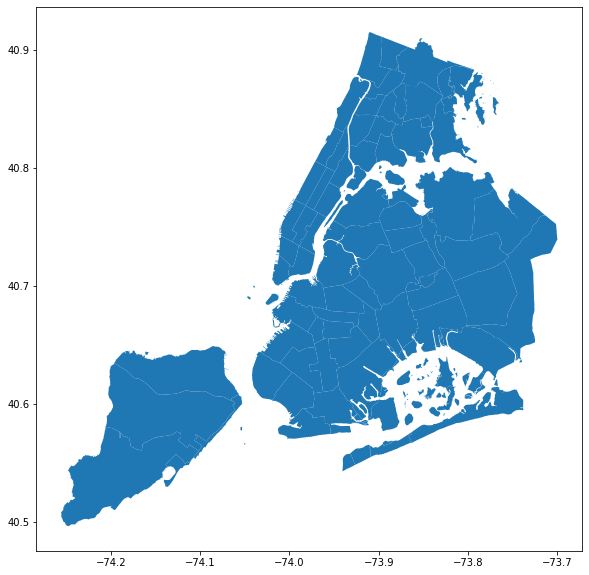

In [43]:
fig,ax = plt.subplots(figsize= (12,10))
gis_df.plot(ax=ax)

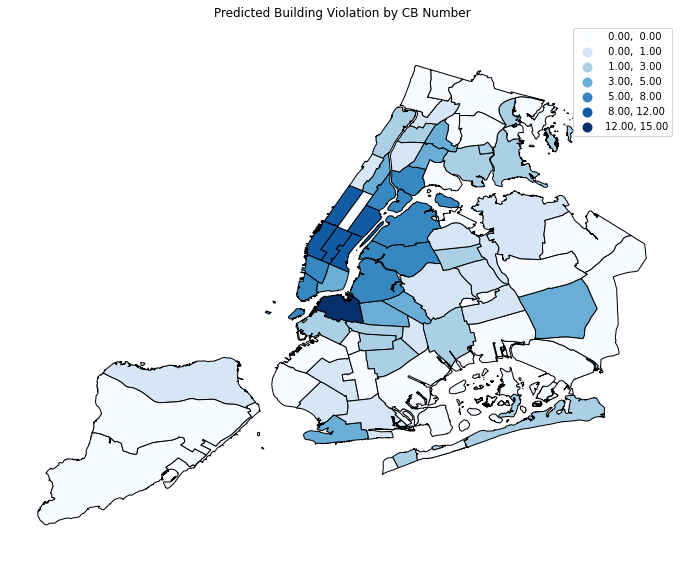

In [44]:
f, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title('Predicted Building Violation by CB Number')
geo_merge.plot(column='High Risk Building Count', scheme='fisher_jenks', k=7, 
                         cmap=plt.cm.Blues, edgecolor='black',legend=True, ax=ax)
ax.set_axis_off()
plt.axis('equal');